# 2.5 自动微分

In [1]:
#求导几乎是所有深度学习优化计算的关键步骤
#深度学习框架通过自动计算导数，即自动微分来加快求导。
#实际中，根据我们设计的模型，系统会构建一个计算图，来跟踪计算是哪些数据通过哪些操作组合起来产生输出
#自动微分使系统能够随后反向传播梯度，反向传播梯度意味着跟踪整个计算图，填充关于每个参数的偏导数

## 2.5.1 一个简单的例子

#### 对函数关于列向量x求导
$$y=2x^T{x}$$

In [2]:
#创建变量x并为其分配一个初始值
import torch
x = torch.arange(4.0)
x

D:\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
D:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


tensor([0., 1., 2., 3.])

In [3]:
#计算y关于x的梯度之前，需要一个地方来存储梯度。我们不会在每次对一个参数求导时都分配新的内存。
#因为我们会成千上万次地更新相同的参数，每次都分配新的内存可能很快就将内存耗尽
#一个标量函数关于向量x的梯度是向量，并且具有与x相同的形状

x.requires_grad_(True) #等价于x=torch.arange(4.0, requires_grad=True)
x.grad #默认值是none

In [4]:
#计算y

#x是长度为4的向量，计算x和x的点积，得到了我们赋值给y的标量的输出
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

In [5]:
#调用反向传播函数来自动求y关于x每个分量的梯度，并打印这些梯度
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

$$y=2x^Tx关于x的梯度应为4x$$

In [6]:
x.grad == 4 * x

tensor([True, True, True, True])

In [7]:
#现在让我们计算x的另一个函数

#默认情况下，Pytorch会累积梯度，我们需要清除之前的值
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

## 2.5.2 非标量变量的反向传播

In [8]:
#当y不是标量时，向量y关于向量x的导数的最自然的解释是一个矩阵，对于高阶和高维的y和x,求导的结果可以是一个高阶张量
#当我们调用向量的反向计算时，我们通常会试图计算一批训练样本中每个组成部门的损失函数的导数
#我们的目的不是计算微分矩阵，而且是单独计算批量中每个样本的偏导数之和

#对非标量调用backward需要传入一个gradient参数，该参数指定微分函数关于self的梯度
#在我们的例子中，我们只想求偏导数的和，所以传递一个1的梯度是合适的
x.grad.zero_()
y = x * x
#等价于y.backward(torch.ones(len(x)))
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

## 2.5.3 分离计算

In [9]:
#有时我们希望将某些计算移动到记录的计算图之外。例如，假设y是作为x的函数计算的，而z则是作为y和x的函数计算的。
#想象一下，我们想计算z关于x的梯度，但由于某种原因，我们希望将y视为一个常数，并且只考虑x在y被计算后发挥的作用。

#当我们再训练网络的时候可能希望保持一部分的网络参数不变，只对其中一部分的参数进行调整
#或者值训练部分分支网络，并不让其梯度对主网络的梯度造成影响，这时候我们就需要使用detach()函数来切断一些分支的反向传播

#在这里，我们可以分离y来返回一个新变量u，该变量与y具有相同的值，但丢弃计算图中计算y的任何信息。
#换句话说，梯度不会流经u到x。因此，下面的反向传播函数计算z=u*x关于x的偏导数，同时将u作为常数处理，而不是z=x*x*x关于x的偏导数
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

In [10]:
#由于记录了y的结果，我们可以随后在y上调用反向传播，得到y=x*x关于x的导数，即2x
x.grad.zero_()
y.sum().backward()
x.grad ==  2 * x

tensor([True, True, True, True])

## 2.5.4 Python控制流的梯度计算

In [11]:
#使用自动微分的一个好处是，即使构建函数的计算图需要通过Python控制流（例如条件、循环或任意函数的调用），我们仍可以计算得到的变量的梯度

#while循环的迭代次数和if语句的结果都取决于输入a的值
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [12]:
#计算梯度
a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

In [13]:
#现在可以分析上面定义的f函数，它在其输入a中是分段线性的

#对于任何a，存在某个常量标量k，使得f(a)=k*a，其中k的值取决于输入a，因此可以用d/a验证梯度是否正确
a.grad == d/a

tensor(True)

## 2.5.5 小结

In [14]:
#深度学习矿界可以自动计算导数：我们首先将梯度附加到要对其计算偏导数的变量上，然后我们记录目标值的计算，
#执行它的反向传播函数，并访问得到的梯度

## 2.5.6 练习

In [15]:
#1.为什么计算二阶导数比一阶导数的开销要大？

#因为二阶导数是一阶导数的导数

In [16]:
#2.在运行反向传播之后，立即再次运行它，看看会发生什么？

import torch
from d2l import torch as d2l

x = torch.arange(4.0, requires_grad=True)
y = x * x
y.sum().backward()
y.sum().backward()
x.grad

RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling .backward() or autograd.grad() the first time.

In [43]:
#如果需要连续调用backward(),则需要用到retain_graph=True
x = torch.arange(4.0, requires_grad=True)
y = x * x
y.sum().backward(retain_graph=True)
y.sum().backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [46]:
#3.在控制流的例子中，我们计算d关于a的导数，如果我们将变量a更改为随机向量或矩阵，会发生什么？
#4.重新设计一个求控制流梯度的例子，运行并分析结果。

def f(a):
    b = a * a
    for i in range(5):
        b = b + i
    if b.norm() >= 0:
        d = b + 10
    return d
a1 = torch.randn(10, requires_grad=True)
b1 = f(a1)
b1.backward() #若a是向量，b也是向量，则没法直接用反向传播

RuntimeError: grad can be implicitly created only for scalar outputs

In [47]:
b1.sum().backward(retain_graph=True)#retain_graph=True，经测试控制流连续反向传播会报错，清除梯度也没有用
a1.grad

tensor([ 2.3446, -0.6273, -2.1274, -2.2438,  0.2147,  2.0666,  2.8703,  0.9213,
         4.3893,  0.3550])

In [48]:
b1.backward(torch.ones_like(a1))#对非标量进行反向传播需要传入一个'gradient'参数，该参数指定微分函数关于'self'的梯度
a1.grad

tensor([ 4.6891, -1.2546, -4.2549, -4.4876,  0.4293,  4.1332,  5.7406,  1.8427,
         8.7786,  0.7100])

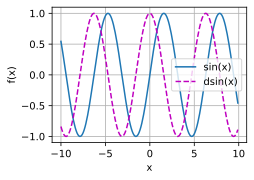

In [54]:
#5.使f(x)=sin(x),绘制f(x)和df(x)/dx的图像，其中后者不使用f'(x)=cos(x)
x = torch.arange(-10, 10, 0.1, requires_grad=True, dtype=torch.float32)#用法同np.arange，生成自变量向量
y = torch.sin(x) #求出x[i]的sin值
grad = torch.zeros_like(y) #创建保存f'(x[i])导数的向量grad
x1 = x.detach().numpy() #tensor转array才能调用绘图函数
y1 = y.detach().numpy()
for i in range(len(grad)): #求sin(x)在每个x[i]的导数
    y[i].backward(retain_graph=True) #隐式自动求导
    grad[i] = x.grad[i]
grad.numpy()
d2l.plot(x1, [y1, grad], 'x', 'f(x)', legend=['sin(x)', 'dsin(x)']) #调用上一个文章的绘图函数